In [21]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/Ensemble Learning_Joe Anthonie Oktavian/adult.csv'
df = pd.read_csv(path)
df.head()




Mounted at /content/drive


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [5]:
target_col = 'income' if 'income' in df.columns else df.columns[-1]
y_raw = df[target_col].astype(str).str.strip()
y = (y_raw == '>50K').astype(int)

In [6]:
X = df.drop(columns=[target_col])
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

In [10]:
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
    remainder='passthrough'
)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [12]:
rf_pipeline = Pipeline([('pre', preprocessor),
                        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])

In [14]:
ada_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=50,
        random_state=42
    ))
])


In [15]:
rf_pipeline.fit(X_train, y_train)
ada_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['workclass', 'education',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native.country'])])),
                ('clf',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                    random_state=42))])

In [16]:
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_ada = ada_pipeline.predict(X_test)

In [17]:
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_ada = accuracy_score(y_test, y_pred_ada)

In [18]:
print(f"RandomForest accuracy: {acc_rf:.4f}")
print(f"AdaBoost accuracy:     {acc_ada:.4f}")
print(classification_report(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_ada))
print(confusion_matrix(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_ada))

RandomForest accuracy: 0.8480
AdaBoost accuracy:     0.8480
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      7417
           1       0.71      0.61      0.66      2352

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      7417
           1       0.74      0.57      0.65      2352

    accuracy                           0.85      9769
   macro avg       0.81      0.75      0.77      9769
weighted avg       0.84      0.85      0.84      9769

[[6839  578]
 [ 907 1445]]
[[6934  483]
 [1002 1350]]


In [19]:
ohe = rf_pipeline.named_steps['pre'].named_transformers_['cat']
cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
all_feature_names = cat_feature_names + numeric_cols
rf_importances = rf_pipeline.named_steps['clf'].feature_importances_

In [20]:
feat_imp_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp_df.head(10))

                               Feature  Importance
102                             fnlwgt    0.154561
101                                age    0.142787
104                       capital.gain    0.097466
106                     hours.per.week    0.084533
27   marital.status_Married-civ-spouse    0.065676
103                      education.num    0.064031
47                relationship_Husband    0.043667
105                       capital.loss    0.029575
29        marital.status_Never-married    0.021490
36          occupation_Exec-managerial    0.018854


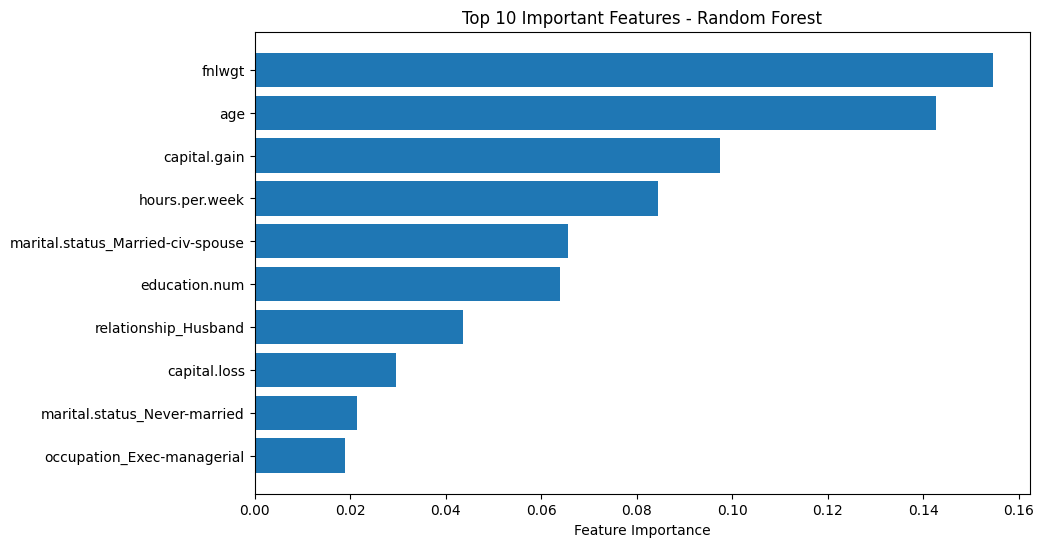

In [22]:
top_features = feat_imp_df.head(10)
plt.figure(figsize=(10,6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features - Random Forest')
plt.show()